# DSCI 512 lab 4

Important notes:

1. This lab revolves around a single application area (resizing images), which is described below as the introduction to the lab.
2. This lab looks very long. Do not despair! A lot of it is text and code for you to read, rather than write.
3. There's a [post on the MDS blog](https://ubc-mds.github.io/2017-10-18-discrete_optimization/) about this lab that may be of interest, especially after you're done.

In [1]:
import numpy as np
import pandas as pd

from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt

import pulp  

## Instructions
rubric={mechanics:8}

Follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).

## "Pre-lab" exercise: colour images

Before we get to seam carving, we need to take a slight detour into how colour images are represented in a computer. Below, we load an image and display it using Python:

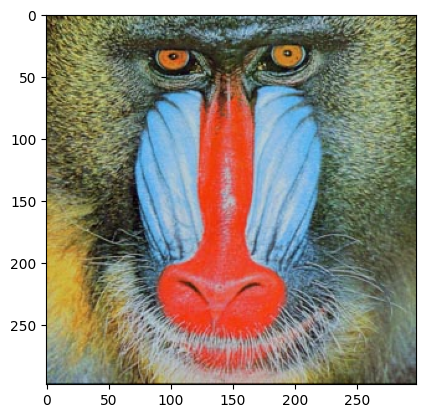

In [2]:
mandrill = plt.imread("mandrill.jpg")
plt.imshow(mandrill);

The variable `mandrill` is just a numpy array:

In [3]:
type(mandrill)

numpy.ndarray

In this case, the numpy array contains integers:

In [4]:
mandrill.dtype

dtype('uint8')

What are its values?

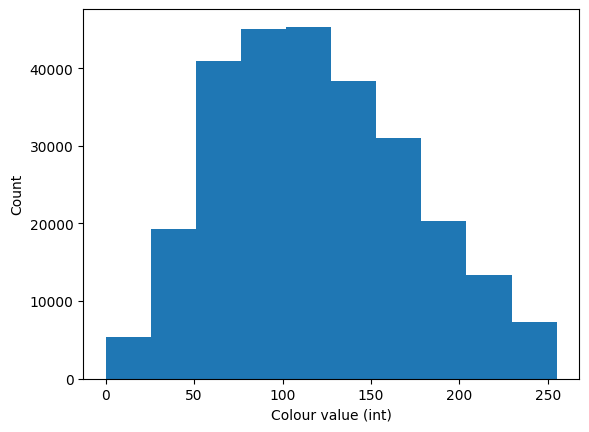

In [5]:
plt.hist(mandrill.flatten());
plt.xlabel("Colour value (int)");
plt.ylabel("Count");

**Note**: I am reverting back to matplotlib (as opposed to Altair) for this lab because I need to render images, which is more familiar to me in matplotlib. It doesn't hurt to see both systems in any case. Sorry for the confusion. The good news is that you don't have to write any plotting code in this lab, just run the code that's already here.

From the histogram above, we see that the values in the `mandrill` array range from 0 to 255. This is quite common, and brings us to one of the biggest nuisances of working with images: if they are integers they should be between 0 and 255 in order to display properly, but if they are floats they should be between 0 and 1 in order to display properly. Look what happens if we try to visualize the image after making it into floats:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


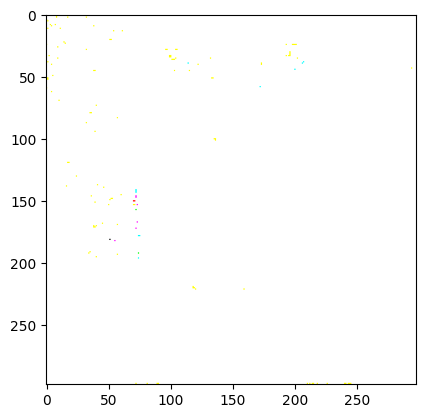

In [6]:
mandrill = mandrill.astype(float)
plt.imshow(mandrill);

The warning explains the issue. To deal with this, I will divide all the values by 255 so they are now between 0 and 1. This is very common practice.

In [7]:
mandrill = mandrill / 255.

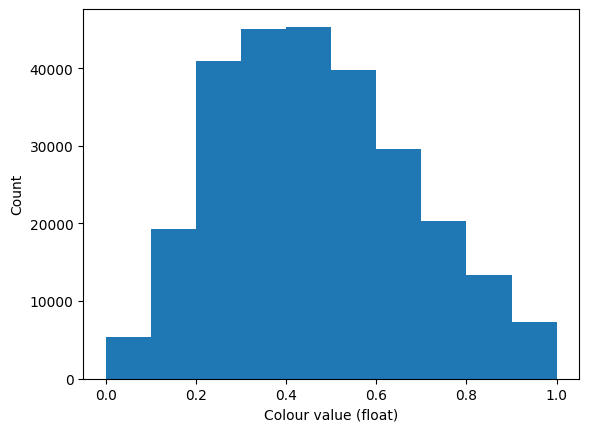

In [8]:
plt.hist(mandrill.flatten());
plt.xlabel("Colour value (float)");
plt.ylabel("Count");

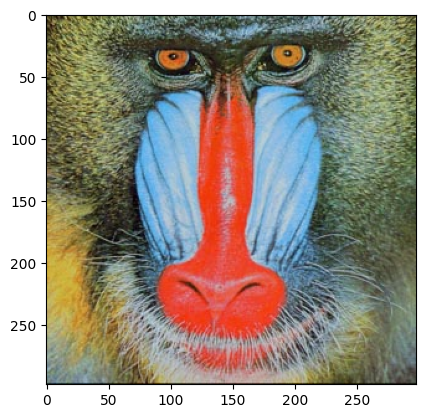

In [9]:
plt.imshow(mandrill);

Ok, we're back on solid ground. It wasn't strictly necessary to change the type from integer to float, but it's generally a good idea and weird unexpected things can sometimes happen if we don't do this. You'll often see this in people's code. 

Now, let's get back to it. We know the image is represented as a numpy array full of floats between 0 and 1, but what are the dimensions of this array?

In [10]:
mandrill.shape

(298, 298, 3)

This is a key point: `mandrill` is a 3D array: it has 298 rows by 298 columns by 3 _colour channels_. By default, the 3 colour channels are red, green and blue. That is,

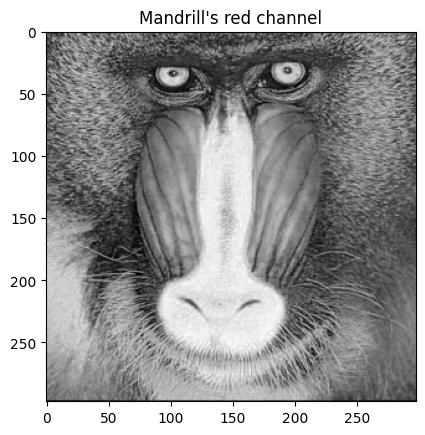

In [11]:
red_channel = mandrill[:, :, 0]
plt.imshow(red_channel, cmap="gray");
plt.title("Mandrill's red channel");

shows the red information content of the image. Notice that the nose is bright (close to white) in the red channel - that's because the nose is red. We can also check out the green and blue channels:

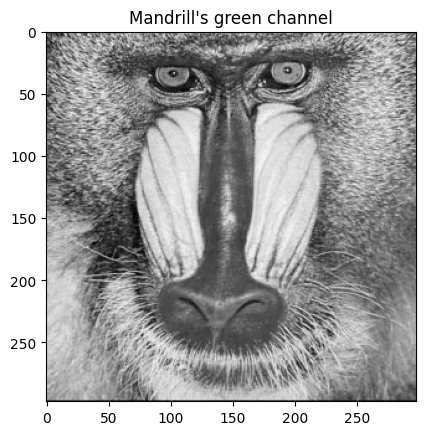

In [12]:
green_channel = mandrill[:, :, 1]
plt.imshow(green_channel, cmap="gray");
plt.title("Mandrill's green channel");

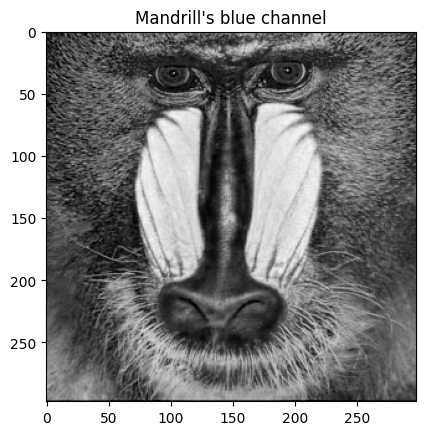

In [13]:
blue_channel = mandrill[:, :, 2]
plt.imshow(blue_channel, cmap="gray");
plt.title("Mandrill's blue channel");

If you are interested in reading more about how colours are represented, you can read up on it, for example [here](https://en.wikipedia.org/wiki/Channel_(digital_image)) and [here](https://en.wikipedia.org/wiki/Color_space), but it's not needed for this lab.

#### Your task
rubric={reasoning:2}

Your task for this section is to swap the red and green channels of this mandrill image and display the result. Then, discuss your results in 1-2 sentences.

Note: this exercise is not used for the rest of the lab; rather, it is meant as a practice exercise for working with RGB colour images.

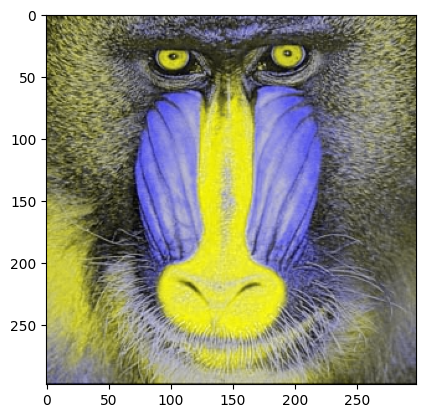

In [14]:
# green to red swap
mandrillSwp = mandrill
mandrillSwp[:,:,1],mandrillSwp[:,:,0] = mandrillSwp[:,:,0],mandrillSwp[:,:,1]
plt.imshow(mandrillSwp)
del mandrillSwp

## Now we start the main part of the lab

##### Motivation
We often want to resize images (say, for different screen sizes/resolutions). A standard solution to make an image smaller would be to just discard some of the pixels. For example, if we want to make the image exactly half its original width and height, we can cut up the images into $2\times 2$ squares and just keep the upper-left pixel in each square. But what if you want to reduce the size of the image by 30%? Or, what if you want to change the aspect ratio of the image without stretching the image contents? Now things get more complicated. 

Here, we will explore a technique called _seam carving_. If you are interested, you can check out the 2007 paper by Shai Avidan and Ariel Shamir [_Seam Carving for Content-Aware Image Resizing_](https://www.researchgate.net/profile/Ariel-Shamir/publication/215721610_Seam_Carving_for_Content-Aware_Image_Resizing/links/55f7b1ce08aec948c472947e/Seam-Carving-for-Content-Aware-Image-Resizing.pdf). As the title of the paper suggests, this algorithm is about "content-aware" image resizing, which means that the pixels we add/remove are chosen based on the content itself. With seam carving, we can resize to any size, not just nice fractions like double or half. You may find this 5-minute video about Seam Carving helpful: https://www.youtube.com/watch?v=6NcIJXTlugc
 
Note: in this lab we will consider only the problem of making an image smaller. Seam carving can also be used to make an image larger but we skip that here in the interest of time. 

##### What's the basic idea?

Seam carving works by removing _seams_, one at a time. What is a seam? A _vertical seam_ is a connected path from the top to the bottom of the image, where the seam contains one pixel in each row. Similarly, a _horizontal seam_ is a connected path from the left to the right of the image, where the seam contains one pixel in each column. The image below shows a vertical seam and a horizontal seam, both in red.

And, when we say a "connected" path, what do we mean by connected? Definition: a connected vertical (horizontal) path is a sequence of pixels, one per row (column), such that each pair of adjacent pixels is at most one column (row) apart. In other words, as you move down the image to create a vertical seam, you can only move diagonally or straight down; you can't move to a pixel that is further away.

![](http://www.ulfdittmer.com/imagej/imret-Im1.jpg)

Seam carving works by repeatedly removing (or adding) seams until the desired size is achieved. You do not need to worry about this part: you are  provided with the function `seam_carve` that takes in an image and a desired size, and finds/removes the seams until the desired size is reached. You are only responsible for writing function `find_vertical_seam`. This is the interesting part.

##### How do we assess the quality of a seam? 
Seam carving works by defining an _energy function_, which is a proxy for how important each pixel is. You do not need to  understand how energy is computed (it should make more sense in a few months, after DSCI 572). Instead, we provide you with a function `energy` that takes in an image and returns an array of the same size containing the energy values. For those who are interested in what makes a good energy function, you can refer to the original paper (the basic idea is that when pixel intensities vary more rapidly, this indicates a more important part of the image, and thus higher energy). Next, assuming you have the energy image in hand, a vertical or horizontal seam is simply the minimum energy connected dpath from top to bottom, or left to right, respectively.

In the three parts below, you will consider a few different methods for finding the best seam out of all possible seams. You will discover that there are many ways of solving the same problem, and some are much better than others!

Below you are provided with a class containing the following functions:
  * `energy` 
  * `find_vertical_seam`
  * `find_horizontal_seam`
  * `remove_vertical_seam`
  * `remove_horizontal_seam`
  * `seam_carve` 

You should understand what they do, but you do not need to understand how they work (this is the beauty of functions!). 

In [15]:
class SeamCarve:

    def energy(self, image):
        """
        Computes the "energy" of an image.

        Parameters
        ----------
        image : numpy.ndarray
            A colour image

        Returns
        -------
        numpy.ndarray
            A new image where the pixels values represent the energy
            of the corresponding pixel in the original image
        """

        dy = np.array([-1, 0, 1])[:, None, None]
        dx = np.array([-1, 0, 1])[None, :, None]
        energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
        return np.sum(energy_img, axis=2)

    def find_vertical_seam(self, energy):
        """
        PLACEHOLDER FUNCTION - This will be replaced further on in the lab.  

        Parameters
        ----------
        energy : numpy.ndarray
            the 2d energy image

        Returns
        -------
        numpy.ndarray
            an array containing all zeros
        """

        return np.zeros(energy.shape[0])

    def find_horizontal_seam(self, energy):
        """
        Find the minimum-energy horizontal seam in an image. 

        Parameters
        ----------
        energy : numpy.ndarray
            a 2d numpy array containing the energy values. Size NxM

        Returns
        -------
        numpy.ndarray
            a seam represented as a 1d array of length M, with all values between 0 and N-1
        """

        return self.find_vertical_seam(energy.T)

    def remove_vertical_seam(self, image, seam):
        """
        Remove a vertical seam from an image.

        Parameters
        ----------
        image : numpy.ndarray
            a 3d numpy array containing the pixel values
        seam : numpy.ndarray
            a 1d array (or list) containing the column index of each pixel in the seam
            length N, all values between 0 and M-1

        Returns
        -------
        numpy.ndarray
            a new image that is smaller by 1 column. Size N by M-1.
        """

        height = image.shape[0]
        linear_inds = np.array(seam)+np.arange(image.shape[0])*image.shape[1]
        new_image = np.zeros(
            (height, image.shape[1]-1, image.shape[-1]), dtype=image.dtype)
        for c in range(image.shape[-1]):
            temp = np.delete(image[:, :, c], linear_inds.astype(int))
            temp = np.reshape(temp, (height, image.shape[1]-1))
            new_image[:, :, c] = temp
        return new_image

    # Same as remove_vertical_seam above, but for a horizontal seam. The output image is size N-1 by M.
    def remove_horizontal_seam(self, image, seam):
        """
        Remove a horizontal seam from an image.

        Parameters
        ----------
        image : numpy.ndarray 
            a 2d numpy array containing the pixel values. Size NxM
        seam : numpy.ndarray
            a 1d array containing the column index of each pixel in the seam
            length N, all values between 0 and M-1.

        Returns
        -------
        numpy.ndarray
            a new image that is smaller by 1 row. Size N-1 by M.
        """

        return np.transpose(self.remove_vertical_seam(np.transpose(image, (1, 0, 2)), seam), (1, 0, 2))

    def seam_carve(self, image, desired_height, desired_width, plot=False):
        """
        Resize an NxM image to a desired height and width. 
        Note: this function only makes images smaller. Enlarging an image is not implemented. 
        Note: this function removes all vertical seams before removing any horizontal
        seams, which may not be optimal.

        Parameters
        ----------
        image : numpy.ndarray
            a 3d numpy array of size N x M x 3
        desired_width : int 
            the desired width
        desired_height : int 
            the desired height
        plot : bool (default = False)
            whether or not to plot the seams as you go along
            
        Returns
        -------
        numpy array
            the resized image, now of size desired_height x desired_width x 3

        Example
        ------- 
        >>> sc = SeamCarve()
        >>> image = np.array([[[0.2 , 0.1 , 0.6 ], [0.4 , 0.5 , 0.65]], [[0.3 , 0.7 , 0.3 ], [0.8 , 0.33, 0.7 ]]])
        >>> sc.seam_carve(image, 1, 1 )
        array([[[0.8 , 0.33, 0.7 ]]])
        """

        while image.shape[1] > desired_width:
            seam = self.find_vertical_seam(self.energy(image))
            assert len(seam) == image.shape[0], "the length of the seam must equal the height of the image"
            
            if plot:
                plt.imshow(image)
                plt.plot(seam, np.arange(image.shape[0]), linewidth=5);
                plt.show()
            
            image = self.remove_vertical_seam(image, seam)
            print('\rWidth is now %d' % image.shape[1], end='')
        print()
        while image.shape[0] > desired_height:
            seam = self.find_horizontal_seam(self.energy(image))
            assert len(seam) == image.shape[1], "the length of the seam must equal the width of the image"
            
            if plot:
                plt.imshow(image)
                plt.plot(np.arange(image.shape[1]), seam, linewidth=5);
                plt.show()

            image = self.remove_horizontal_seam(image, seam)
            print('\rHeight is now %d' % image.shape[0], end='')
        print()
        
        if plot:
            plt.imshow(image)
        
        return image

Below is some test code that works on a tiny image (which is a screenshot from the incredible puzzle game [Line of Sight](https://joel-fox.itch.io/line-of-sight)). We use a tiny image because the recursive solution is so slow that you wouldn't be able to test the code on any larger images.

In [83]:
img = plt.imread("line_of_sight.png")[:, :, :3]
img.shape

(10, 10, 3)

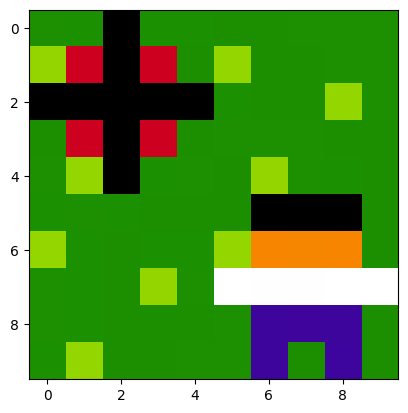

In [17]:
plt.imshow(img);

In [18]:
sc = SeamCarve()

Here is the energy image for the above image:

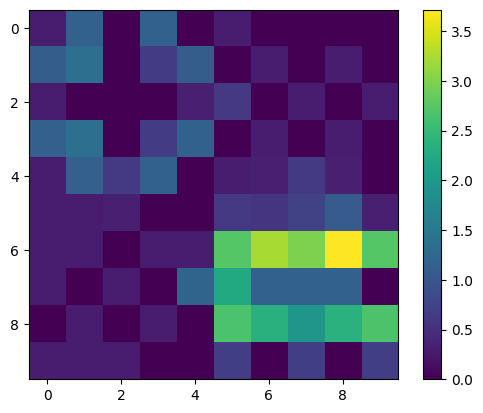

In [19]:
plt.imshow(sc.energy(img));
plt.colorbar();

As you can see, the energy is higher around the person and around the cross, but lower on the grass.

Let's run the (not yet fully implemented) seam carving code:

Width is now 7
Height is now 7


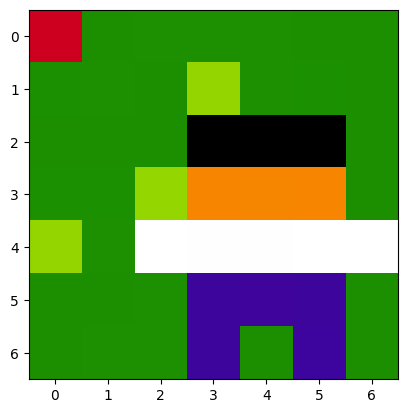

In [20]:
new_height = 7
new_width = 7

img2 = sc.seam_carve(img, new_height, new_width)

plt.imshow(img2);

Again, the above is not a real seam carving because it is using placeholder `find_vertical_seam` function that just removes the first column of the image (and likewise for horizontal seams). Below we will get to the real seam carving.

## Part 1: recursive implementation

What's the natural way of finding the best (lowest energy) seam? Well, just consider all possible paths, compute the total energy for each one, and take the minimum, right? We have provided a recursive implementation that follows this brute force approach. The code is below. 

In [21]:
def fvs(energy, seam, cost):
    """
    The "inner" recursive function for finding a vertical seam.

    Parameters
    ----------
    energy : numpy.ndarray
        the 2d energy image
    seam : list
        the partial seam (from the top, partway down the image)
    cost : float
        the cost of the partial seam

    Returns
    -------
    tuple 
        contains the seam and the energy cost

    Example
    -------    
    >>> fvs(np.array([[0.6625, 0.3939], [1.0069, 0.7383]]), [1], 0.0)
    ([1, 1], 1.1321999999999999)
    """

    row = len(seam)-1
    col = seam[-1]

    # if out of bounds on one of the two sides, return infinite energy
    if col < 0 or col >= energy.shape[1]:
        return seam, np.inf

    cost += energy[row, col]

    # regular base case: reached bottom of image
    if len(seam) == energy.shape[0]:
        return seam, cost

    return min((fvs(energy, seam+[col], cost),
                fvs(energy, seam+[col+1], cost),
                fvs(energy, seam+[col-1], cost)), key=lambda x: x[1])
    # above: could make syntax nicer if I was willing to tolerate some more inefficiency
    # by defining an energy function of seam and re-computing energy of the seam each time


class SeamCarveRecursive(SeamCarve):

    def find_vertical_seam(self, energy):
        """
        Finds the vertical seam of lowest total energy inside the image.

        Parameters
        ----------
        energy : numpy.ndarray
            the 2d energy image

        Returns
        -------
        list 
            the seam of column indices

        Example
        -------  
        >>> sc_recursive = SeamCarveRecursive()
        >>> e = np.array([[0.6625, 0.3939], [1.0069, 0.7383]])
        >>> sc_recursive.find_vertical_seam(e)
        (1, 1)
        """
        
        costs = dict()
        for i in range(energy.shape[1]):
            best_seam, best_cost = fvs(energy, [i], 0.0)
            costs[tuple(best_seam)] = best_cost
        return min(costs, key=costs.get)  # the best out of the M best seams


**Note**: here, we are using _inheritance_, which I believe you covered in DSCI 511. You can see above in the code `class SeamCarveRecursive(SeamCarve):`. The idea here is that we made a new class called `SeamCarveRecursive` which is more or less a copy of the original class `SeamCarve`, except we are allowed to modify/augment it. The only modification we're making is overwriting the `find_vertical_seam` function with a new version. All the other functions are carried over from the original `SeamCarve` class. This is convenient because we don't need to copy/paste all the other functions from `SeamCarve` into `SeamCarveRecursive`, which makes for more maintainable and DRY-compliant lab code. What we're doing here is for educational purposes; this is not exactly the standard purpose of inheritance. 

Width is now 7
Height is now 7


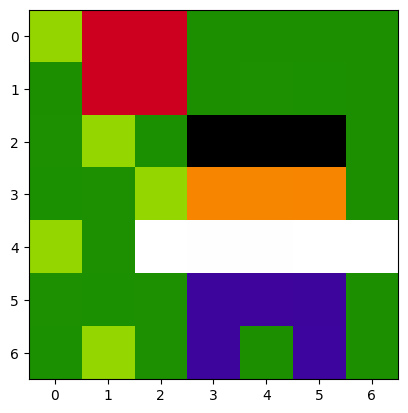

In [22]:
sc_recursive = SeamCarveRecursive()

new_height = 7
new_width = 7

test_img_small_rec = sc_recursive.seam_carve(img, new_height, new_width)

plt.imshow(test_img_small_rec);

If you want to see how the seams get removed one by one (and this may be a useful debugging tool throughout the lab) you can set `plot=True` when you call `seam_carve`:

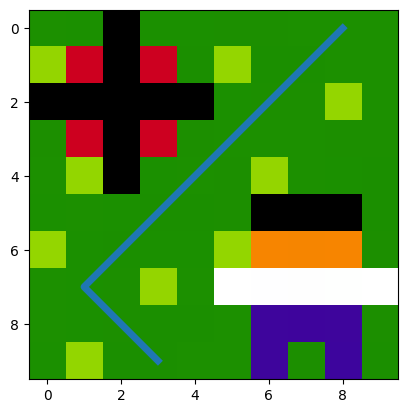

Width is now 9

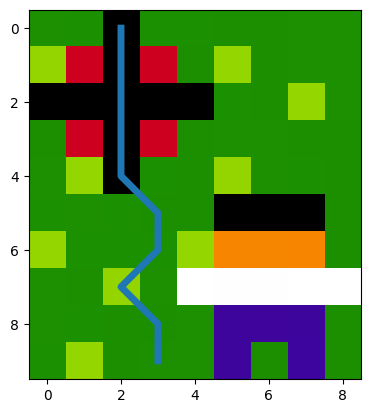

Width is now 8

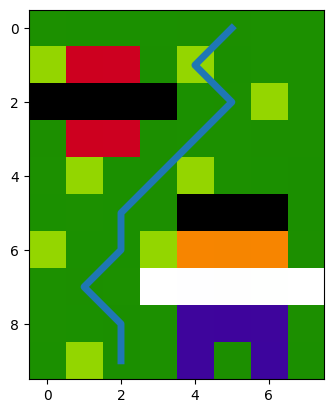

Width is now 7


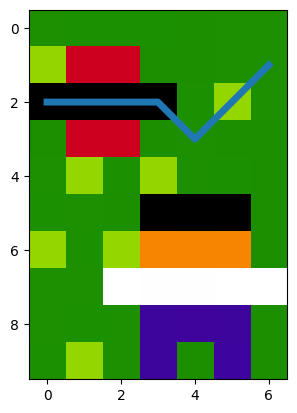

Height is now 9

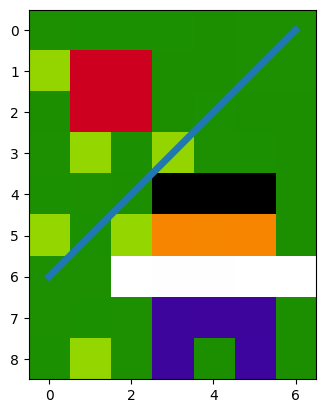

Height is now 8

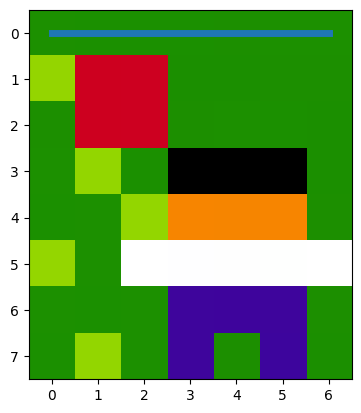

Height is now 7


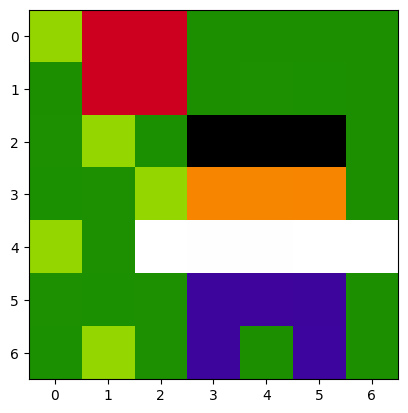

In [23]:
test_img_small_rec = sc_recursive.seam_carve(img, new_height, new_width, plot=True)


In [42]:
#testEnergy = sc.energy(img)
testEnergy.shape[1]

10

The seams are shown as a blue line. Note that there are 3 vertical seams followed by 3 horizontal seams, because the code is set up to remove all the vertical seams (reduce width) and then remove all the horizontal seams (reduce height). 

This is kind of cool, right?

#### 1(a)
rubric={reasoning:1}

Briefly describe the results on the test image above. Are they the same as just removing the first few rows and columns?

no, as expressed above you look for the least amount of pixel density and remove it, this is different from just dropping first few rows and columns which may seem like cropping an image.

#### 1(b)
rubric={reasoning:3}

What is the time complexity of `find_vertical_seam`, as a function of the image height $N$ and image width $M$? You don't necessarily have to read through all the code carefully to answer this, you can just think about the process of enumerating all possible seams. Also, keep in mind that big-O is an upper bound - it's not technically wrong to say binary search takes $O(n^{100})$ time, it's just unhelpful and confusing to say so. So if you're not exactly sure what the answer is, it would be better to pick something too large than too small.

its  O(n^n), as for every n it recursively looks for the minimum, and repeats itself for every vertical seam.

#### (optional) 1(c)
rubric={reasoning:1}

Empirically test out your time complexity answer. For simplicity, first fix $N=5$ and measure the running time of `find_vertical_seam` as you vary $M$. Then, fix $M$ and measure the running time of `find_vertical_seam` as you vary $N$. Are your results consistent with your theory? Briefly explain.

Note: you may want to randomly generate the images so that you can get an input image of any size you want.

the results are not consistent, as the algorithim runs on constant time does tend to coverge on 605 ms for both fixing M and N, however an interesting thing to note is that as established above the veritcal check is done before the horizontal hence the algorithim is faster on the horizontal seam than the vertical.

In [71]:
def generate_img_dim(img,dimx,dimy):
    """
    returns line of best sight in the dimensions provided
    """
    return(img[dimx,dimy,3])
for i in range(7,15):
    %timeit    sc_recursive.seam_carve(img[5::], i, 5)

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is now 5

Width is

In [51]:
# empirically testing out if the theory stated above works.
import timeit
sc_recursive = SeamCarveRecursive()

new_height = 7


for i in range(7,14):
    new_width = i
    print(timeit.timeit("sc_recursive.seam_carve(img, new_height, new_width)",globals=globals()))

Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is now 7
Height is now 7
Width is

KeyboardInterrupt: 

#### 1(d)
rubric={accuracy:1}

What is the largest square image in which `find_vertical_seam` runs in 10 seconds or less?

Note: you may want to randomly generate the images so that you can get an input image of any size you want.

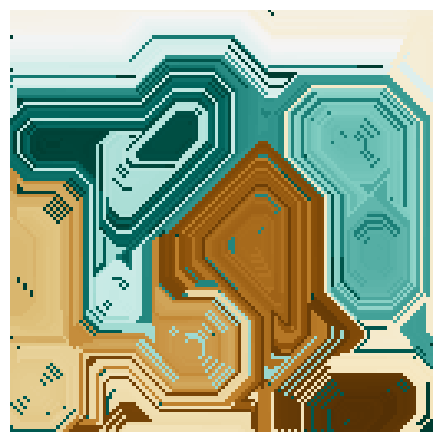

In [74]:
from randimage import get_random_image, show_array
img_size = (128,128)
img = get_random_image(img_size)  #returns numpy array
show_array(img) #shows the image

In [77]:
## takes too long to run
img_size = (128,128)
for i in range(128,1080):
    if i%2==0:
        img_size = (i,i)
        img = get_random_image(img_size)
        %timeit    sc_recursive.seam_carve(img, 5, 5)

KeyboardInterrupt: 

## Part 2: integer linear program

Hopefully it's possible to do better than enumerating all possible seams. Here, we will try an approach that takes advantage of the _linearity_ of the problem. To pick a seam, let's define $NM$ binary variables $x_{ij}$, where $i$ represents the row and $j$ represents the column, so that we have one variable for each pixel (note: a binary variable means a variable that can only take on the values 0 or 1). We now need to write down our objective and constraints.

Here are our constraints:

1. A vertical seam can only have one pixel per row.
2. If pixel $(i,j)$ is in the seam and $i<N$, then one of $(i+1,j-1)$, $(i+1,j)$, or $(i+1,j+1)$ must be in the seam. 

And, our objective is the sum of the energies of all pixels where $x_{ij}$ is 1.

#### 2(a)
rubric={accuracy:4}

Complete the `find_vertical_seam` function below using the [PuLP Python package](http://pythonhosted.org/PuLP/). Most of the code is provided for you, but you need to fill some small parts of it of it in.

Make sure your code gives the same result as your recursive implementation, for the small test image.

**Note:** unlike numpy arrays, the way we're using PuLP you must index into `x` like `x[i][j]`, not `x[i,j]`.

**Hint:** your code should not include any `if` statements checking if `x[i][j]` is in the seam. It has not yet been decided if any particular `x[i][j]` is in the seam or not, so that wouldn't make sense. Rather, we need to create mathematical expressions involving these `x[i][j]` that correctly encode our objective and constraints. However, your code _after_ `prob.solve()` should do this, because after `prob.solve()` is called then it has been determined whether or not each `x[i][j]` is in the seam.

In [24]:
class SeamCarveILP(SeamCarve):

    def find_vertical_seam(self, energy):
        """
        Finds the vertical seam of lowest total energy inside the image.

        Parameters
        ----------
        energy : numpy.ndarray
            the 2d energy image

        Returns
        -------
        list 
            the seam of column indices

        Example
        -------    
        >>> sc = SeamCarveILP()
        >>> e = np.array([[0.6625, 0.3939], [1.0069, 0.7383]])
        sc.find_vertical_seam(e)
        [1, 1]
        """ 
            
        N, M = energy.shape

        # initialize the optimization problem, give it a name
        prob = pulp.LpProblem("Seam_carving", pulp.LpMinimize)

        # create the x_ij variables
        x = pulp.LpVariable.dicts("pixels",(list(range(N)),list(range(M))),0,1,pulp.LpInteger)

        # The objective function is being built here. The objective is the sum of energies in the seam.
        objective_terms = list()
        for i in range(N):
            for j in range(M):
                # YOUR CODE HERE
                # i am confused on this part do i just add to objective terms, since the way the loop is set up it is going to check every element in the row before changing it.
                x[i][j]
                
        prob += pulp.lpSum(objective_terms) # adds up all the terms in the list

        # Constraint #1: one pixel per row
        # YOUR CODE HERE
        # is this just a min function per row?
        
            
        # Constraint #2: connectivity of seam
        for i in range(N-1):
            for j in range(M): # below: this says: x(i,j) - x(i+1,j-1) - x(i+1,j) - x(i+1,j+1) <= 0
                prob += pulp.lpSum([x[i][j]]+[-x[i+1][k] for k in range(max(0,j-1),min(M,j+2))]) <= 0

        # Solve the problem
        prob.solve(pulp.apis.PULP_CBC_CMD(msg=0))

        # Build up the seam by collecting the pixels in the optimal seam
        # YOUR CODE HERE
        

        return seam
    


IndentationError: expected an indented block (2209037140.py, line 39)

In [ ]:
sc_ilp = SeamCarveILP()

new_height = 7
new_width = 7

test_img_small_ilp = sc_ilp.seam_carve(img, new_height, new_width)

assert np.array_equal(test_img_small_rec, test_img_small_ilp)

plt.imshow(test_img_small_ilp);


#### 2(b)
rubric={reasoning:1}

Compare the speed of `find_vertical_seam` to your recursive implementation. What is the largest square image that this implementation can find a vertical seam from in under 10 s? (An approximate answer is fine, it doesn't have to be perfect to the last pixel.) 

(You are not asked about time complexity here because that is beyond the scope of this course.)

To run the experiment, instead of random images, use the upper-left corner of the mandrill image.

In [ ]:
mandrill = plt.imread('mandrill.jpg')

E.g. for a square image of size 20, take

In [ ]:
mandrill[:20,:20];

This way everyone will be using the same images and it's easier to compare results across students.

#### 2(c)
rubric={reasoning:3}

Given the time complexity of the recursive implementation, how long (very approximately) do you expect it would take to run `find_vertical_seam` on an image of the size from 2(b), which took less than 10 seconds with integer linear program? To approach this question, use your image size that took 10 seconds with the recursive implementation, and then think about how $N$ and $M$ changed. Express your answer in the units of years.

## Part 3: dynamic programming implementation.

In Part 1 we used a brute force approach of considering _all_ possible seams and taking the best one. In Part 2 we took advantage of the linearity of the optimization problem. But, actually, this particular problem has more special structure beyond being linear. Loosely speaking, it is a bunch of sequential decisions, where the total objective is the sum of mini-objectives incurred by each decision (total energy = sum of individual seam pixel energies). This means we can use dynamic programming. Hooray!

To use dynamic programming for seam carving, we create a table of size $N\times M$ (the same size as your energy image) that contains, at location $(i,j)$, the minimum energy required to get from the top of the image to that location. For the first row, this is just the energy value. But for the next row, you might arrive at location $(2,j)$ from 3 possible places, namely $(1,j-1)$, $(1,j)$, or $(1,j+1$). 

Below we provide code that implements `find_vertical_seam` using dynamic programming.

In [84]:
class SeamCarveDP(SeamCarve):

    def find_vertical_seam(self, energy):
        """
        The vertical seam of lowest total energy inside the image.

        Parameters
        ----------
        energy : numpy.ndarray
            the 2d energy image

        Returns
        -------
        list 
            the seam of column indices

        Example
        -------    
        >>> sc = SeamCarveDP()
        >>> e = np.array([[0.6625, 0.3939], [1.0069, 0.7383]])
        sc.find_vertical_seam(e)
        [1, 1]     
        """
        
        nrows, ncols = energy.shape

        # Cumulative Minimum Energy
        CME = np.zeros((nrows, ncols+2))
        CME[:,0] = np.inf
        CME[:,-1] = np.inf
        CME[:,1:-1] = energy
        # if helpful, the above 4 lines are equivalent to these two lines below
        # column_of_inf = np.full((nrows,1), np.inf)
        # CME = np.hstack((column_of_inf, energy, column_of_inf))

        for i in range(1,nrows):
            for j in range(1,ncols+1):
                CME[i,j] += min(CME[i-1,j-1],CME[i-1,j],CME[i-1,j+1])
        
        # create the seam array
        seam = np.zeros(nrows, dtype=int)
        seam[-1] = np.argmin(CME[-1,:])

        # track the path backwards
        for i in range(nrows-2,-1,-1):
            # min_index is 0, 1, or 2. I subtract 1 to give the offset from
            # seam(i+1), namely -1, 0, or 1. Then I add this to the old value.
            delta = np.argmin(CME[i, seam[i+1]-1:seam[i+1]+2]) - 1
            seam[i] = seam[i+1] + delta

        return seam - 1 
        # Above: -1 because the indices are all off by 1, due to padding of CME
        #        This has nothing to do with the -1 in defining "delta'".


Width is now 7
Height is now 7


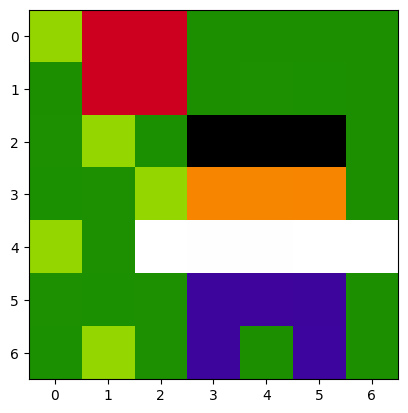

In [85]:
sc_dp = SeamCarveDP()

new_height = 7
new_width = 7

test_img_small_dp = sc_dp.seam_carve(img, new_height, new_width)

assert np.array_equal(test_img_small_rec, test_img_small_dp)

plt.imshow(test_img_small_dp);

#### 3(a)
rubric={reasoning:1}

One possible nuisance is that the leftmost and rightmost columns of the image are special cases: instead of having 3 possible pixels to choose from next, in these cases you only have 2 choices. The implementation above addresses this by "padding" the CME array with `np.inf` on the left and right sides to make a slightly larger image. This way, there are always 3 choices and no special cases or `if` statements are needed.

Briefly explain why the extra columns are given the value of `np.inf` instead of some other number like 0, or 1, etc.

#### 3(b)
rubric={reasoning:2}

Using big-O notation, state the running time of `find_vertical_seam` as a function of the image height $N$ and width $M$.


#### 3(c)
rubric={reasoning:1}

Empirically compare the speed of your DP implementation of `find_vertical_seam` to the ILP implementation from Part 2 -- how long does your DP code take for the image size that took 10 seconds with ILP? 

#### 3(d)
rubric={reasoning:1}

How big of an image you can run `find_vertical_seam` on in 10 seconds with DP?

## Part 4: code vectorization

In Part 3 you took things as far as they will go with better algorithms. But you still might not be satisfied with the performance. The next step is to optimize the implementation of the dynamic programming algorithm. A typical approach would be to ditch Python; while R might not be much faster (maybe it's slower?), other languages like C or perhaps Julia would speed things up. Another approach would be to use parallel computing, in which multiple threads of computation are performed at once. However, changing languages and parallelization are not always the only way. In Part 3, we implemented your forward pass with a nested `for` loop over the rows and columns of the image. However, certain languages (Python/NumPy, R, Matlab, etc.) do _vectorized_ operations much faster than loops.

#### 4(a)
rubric={accuracy:2}

Here you will write a dynamic programming `find_vertical_seam` function with vectorized code. In particular, we will replace the loop over columns in the CME calculation (the inner loop using `j`) with a vectorized operation. To vectorize this inner loop, you will need to use the fact that calling `np.min(x, axis=0)` on a 2-dimensional array `x` takes the minimum across axis 0 (i.e. "vertically"; the minimum of each column) for all columns of `x` in one command, without a loop.

For example, say you needed to find the minimum of $(1,2,3)$ and $(5,6,4)$ and $(9,8,7)$ and $(11,10,12)$ all at once (this is just for illustration purposes). You could do this:

In [ ]:
x = np.array([[1, 2, 3], [5, 6, 4], [9, 8, 7], [11, 10, 12]]).T
x

In [ ]:
np.min(x, axis=0)

This gives you the minimum of each triplet in a vectorized fashion, instead of having to loop over them. (This same syntax applies to many numpy functions, like `sum`, `var`, etc.) 

In this case, we have a row of the energy image, like this (a toy example with only 6 pixels):

```
1 8 3 2 0 1
```

We want to compute the minimums of a bunch of tuples: (1,8) and (1,8,3) and (8,3,2) and (3,2,0) and (2,0,1) and (0,1). Typically we'd use a loop but we want to do this without a loop. The trick is to create a 2D numpy array that looks like this:

```
    1 8 3 2 0 1
  1 8 3 2 0 1
1 8 3 2 0 1
```

This array is the original row repeated 3 times, but shifted over. The size of the above array is 3 rows and M+2 columns.  

Now, numpy arrays have to be rectangular so we need to fill in the empty spaces with some value. As in our dynamic programming implementation in 3(a), a good choice of this value is `np.inf`, which I'll denote using the infinity symbol `∞` for visual purposes. So then we have

```
∞ ∞ 1 8 3 2 0 1
∞ 1 8 3 2 0 1 ∞
1 8 3 2 0 1 ∞ ∞
```

Now let's call the above array `z`. Then, once we have this `z`, we can simply call `np.min(z, axis=0)` to get the minimum of each "column" of `z` (note this has nothing to do with the columns of the image!). This gives us the min of (∞,∞,1) and (∞,1,8) and (1,8,3) and (8,3,2) and (3,2,0) and (2,0,1) and (0,1,∞) and (1,∞,∞). So, we actually get everything we need because infinity is never going to be the minimum.

To implement this vectorized dynamic programming seam carving, _start by copy-pasting the dynamic programming code from Part 3_. Then, the only change you will need to make (other than the name of the class) is replacing these lines:

```python
        for i in range(1,nrows):
            for j in range(1,ncols+1):
                CME[i,j] += min(CME[i-1,j-1],CME[i-1,j],CME[i-1,j+1])
```

with your new vectorized code. The new code is also just a few lines. All the rest of the code is identical.

In [ ]:
class SeamCarveDPVec(SeamCarve):

    def find_vertical_seam(self, energy):
        """
        The vertical seam of lowest total energy inside the image.

        Parameters
        ----------
        energy : numpy.ndarray
            the 2d energy image

        Returns
        -------
        list 
            the seam of column indices

        Example
        -------    
        >>> sc = SeamCarveDP()
        >>> e = np.array([[0.6625, 0.3939], [1.0069, 0.7383]])
        sc.find_vertical_seam(e)
        [1, 1]     
        """
        
        nrows, ncols = energy.shape

        # Cumulative Minimum Energy
        CME = np.zeros((nrows, ncols+2))
        CME[:,0] = np.inf
        CME[:,-1] = np.inf
        CME[:,1:-1] = energy
        # if helpful, the above 4 lines are equivalent to these two lines below
        # column_of_inf = np.full((nrows,1), np.inf)
        # CME = np.hstack((column_of_inf, energy, column_of_inf))
        
        ## ahh is it just np.min(CME[3,:,:]), or is it np.min(CME,axis=0)?
        for i in range(1,nrows):
            for j in range(1,ncols+1):
                CME[i,j] += min(CME[i-1,j-1],CME[i-1,j],CME[i-1,j+1])
        
        # create the seam array
        seam = np.zeros(nrows, dtype=int)
        seam[-1] = np.argmin(CME[-1,:])

        # track the path backwards
        for i in range(nrows-2,-1,-1):
            # min_index is 0, 1, or 2. I subtract 1 to give the offset from
            # seam(i+1), namely -1, 0, or 1. Then I add this to the old value.
            delta = np.argmin(CME[i, seam[i+1]-1:seam[i+1]+2]) - 1
            seam[i] = seam[i+1] + delta

        return seam - 1 
        # Above: -1 because the indices are all off by 1, due to padding of CME
        #        This has nothing to do with the -1 in defining "delta'".


In [86]:
sc_dp_vec = SeamCarveDPVec()

new_height = 7
new_width = 7

test_img_small_dp_vec = sc_dp_vec.seam_carve(img, new_height, new_width)

assert np.array_equal(test_img_small_rec, test_img_small_dp_vec)

plt.imshow(test_img_small_dp_vec);

NameError: name 'SeamCarveDPVec' is not defined

#### 4(b)
rubric={reasoning:1}

Empirically compare the speed to your vectorized DP implementation of `find_vertical_seam` to the non-vecorized DP implementation from Part 3: how long does your vectorized DP code take for the image size that took 10 seconds with ILP, in other words the same size you used in 3(d)?

#### 4(c)
rubric={reasoning:1}

How big of an image you can run `find_vertical_seam` on in 1 second with the vectorized DP? (Note: we aren't asking you to try for 10 seconds because the image would likely be too big to fit in memory!)

#### 4(d)
rubric={reasoning:1}

The original DP code starts like this:

```python
for i in range(1,nrows):
    for j in range(1,ncols+1):
        ...
```

In Part 4(a), we vectorized this inner loop over columns, but we did not vectorize the outer loop over rows. Why didn't we take this one step further and vectorize the loop over rows as well?

## Part 5: Pondering

#### 5(a)
rubric={reasoning:3}

Let's take a moment to reflect on how interesting this all is. You tried 4 approaches and (at least for me), each one is _significantly_ faster than the previous. Amazing! For each of the 3 improvements (over the previous version), was the improvement was due to a better algorithm or a better implementation? 

#### 5(b)
rubric={reasoning:1}

Submit some resized images of your liking. Make sure to include both the original and resized image. You are provided with some test images in this repository: mandrill, Halloween high-res ($2592\times 3888$), Halloween lower-res ($400\times 600$). These are read in below. You can try resizing these, or other images. Have fun!

In [ ]:
mandrill_img = plt.imread("mandrill.jpg")
halloween_img_small = plt.imread("halloween-jack-o-lantern-bucket-with-witch-hat-and-candles-400x600.jpg")
halloween_img_large = plt.imread("halloween-jack-o-lantern-bucket-with-witch-hat-and-candles.jpg")